In [22]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Метод главных компонент
##### Cингулярное матричные разложения

In [23]:
# Модифицированный Грам-Шмидт
def modified_gs(matrix: np.array) -> (np.array, np.array):
    
    n = matrix.shape[1]
    q = np.array(matrix, dtype='float64')
    r = np.zeros((n, n))
    
    for i in range(n):
        a_i = q[:, i]
        r[i, i] = np.linalg.norm(a_i)
        a_i /= r[i, i]
        
        for j in range(i + 1, n):
            a_j = q[:, j]
            r[i, j] = a_i.T @ a_j
            a_j -= r[i, j] * a_i
            
    return q, r

def eigen_qr(A: np.array, iterations=1) -> (np.array, np.array):
    Ak = np.copy(A)
    n = A.shape[0]
    QQ = np.eye(n)
    
    for k in range(iterations):
        Q, R = modified_gs(Ak)
        Ak = R @ Q
        QQ = QQ @ Q

    return Ak, QQ


In [24]:
train_main_df = pd.read_csv('../data/HW_train_main_data.csv')
train_additional_df = pd.read_csv('../data/HW_train_additional_data.csv')

test_main_df = pd.read_csv('../data/HW_test_main_data.csv')
test_additional_df = pd.read_csv('../data/HW_test_additional_data.csv')

In [25]:
train_df = train_main_df.merge(train_additional_df, how='left', on='id')
test_df = test_main_df.merge(test_additional_df, how='left', on='id')

train_df = train_df.fillna(-20)
test_df = test_df.fillna(-20)

In [26]:
# train_df.dropna(inplace=True)

In [27]:
train_df.set_index('id', inplace=True)
test_df.set_index('id', inplace=True)

In [28]:
# # Посмотрим на распределение фичей
# fig, axs = plt.subplots(7, 2, figsize=(12, 14))

# for ax, col in zip(axs.flatten(), train_df.columns):
#     sns.histplot(train_df[col], ax=ax, kde=True)
    
# fig.tight_layout(pad=0.3)
# fig.show()

In [29]:
train_df = train_df[train_df['full_sq'] > 0]

In [30]:
# 2. Построить зависимость средней стоимости квартиры от года и месяца продаж
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
train_df['year'] = train_df['timestamp'].dt.year
train_df['month'] = train_df['timestamp'].dt.month

test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])
test_df['year'] = test_df['timestamp'].dt.year
test_df['month'] = test_df['timestamp'].dt.month

In [31]:
# get week of the year
train_df['week_of_year'] = train_df.timestamp.dt.isocalendar().week
test_df['week_of_year'] = test_df.timestamp.dt.isocalendar().week

# get day of week
train_df['day_of_week'] = train_df.timestamp.dt.weekday
test_df['day_of_week'] = test_df.timestamp.dt.weekday

train_df['timestamp_int'] = train_df.timestamp.astype(int)
test_df['timestamp_int'] = test_df.timestamp.astype(int)

# get ratio of squares
train_df["ratio_life_dash_full_sq"] = train_df["life_sq"] / train_df["full_sq"]
train_df["ration_kitchen_dash_full_sq"] = train_df["kitch_sq"] / train_df["full_sq"]
test_df["ratio_life_dash_full_sq"] = test_df["life_sq"] / test_df["full_sq"]
test_df["ration_kitchen_dash_full_sq"] = test_df["kitch_sq"] / test_df["full_sq"]

# age of building 
train_df['age'] = train_df["build_year"] - train_df['year']
test_df['age'] = test_df["build_year"] - test_df['year']

# difference between full area and living area
train_df['some_extra_sqr_1'] = train_df["full_sq"] - train_df["life_sq"]
test_df['some_extra_sqr_1'] = test_df["full_sq"] - test_df["life_sq"]

In [32]:
train_df

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,apartment condition,...,leisure_facilities,year,month,week_of_year,day_of_week,timestamp_int,ratio_life_dash_full_sq,ration_kitchen_dash_full_sq,age,some_extra_sqr_1
id,,,,,,,,,,,,,,,,,,,,,
30392,2014-12-30,60,36.0,6.0,9.0,1.0,1974.0,3.0,5.0,3.0,...,0,2014,12,1,1,1419897600000000000,0.600000,0.083333,-40.0,24.0
36540,2013-06-28,44,29.0,9.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,...,0,2013,6,26,4,1372377600000000000,0.659091,-0.454545,-2033.0,15.0
94669,2013-09-15,62,60.0,4.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,...,0,2013,9,37,6,1379203200000000000,0.967742,-0.322581,-2033.0,2.0
17531,2013-12-13,33,18.0,4.0,9.0,1.0,1970.0,1.0,6.0,2.0,...,0,2013,12,50,4,1386892800000000000,0.545455,0.181818,-43.0,15.0
32159,2014-02-13,37,14.0,1.0,17.0,1.0,1991.0,1.0,1.0,2.0,...,0,2014,2,7,3,1392249600000000000,0.378378,0.027027,-23.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85589,2013-05-08,58,-20.0,2.0,-20.0,-20.0,-20.0,-20.0,-20.0,-20.0,...,0,2013,5,19,2,1367971200000000000,-0.344828,-0.344828,-2033.0,78.0
11345,2014-04-12,38,-20.0,9.0,17.0,1.0,-20.0,1.0,1.0,-20.0,...,0,2014,4,15,5,1397260800000000000,-0.526316,0.026316,-2034.0,58.0
55519,2013-09-23,55,30.0,9.0,16.0,1.0,2002.0,2.0,8.0,3.0,...,0,2013,9,39,0,1379894400000000000,0.545455,0.145455,-11.0,25.0


In [33]:
train_df.drop('timestamp', axis=1, inplace=True)

/var/folders/c_/t45fjn6j75357jk8wg1gpqsr0000gn/T/ipykernel_13519/2683872929.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show();


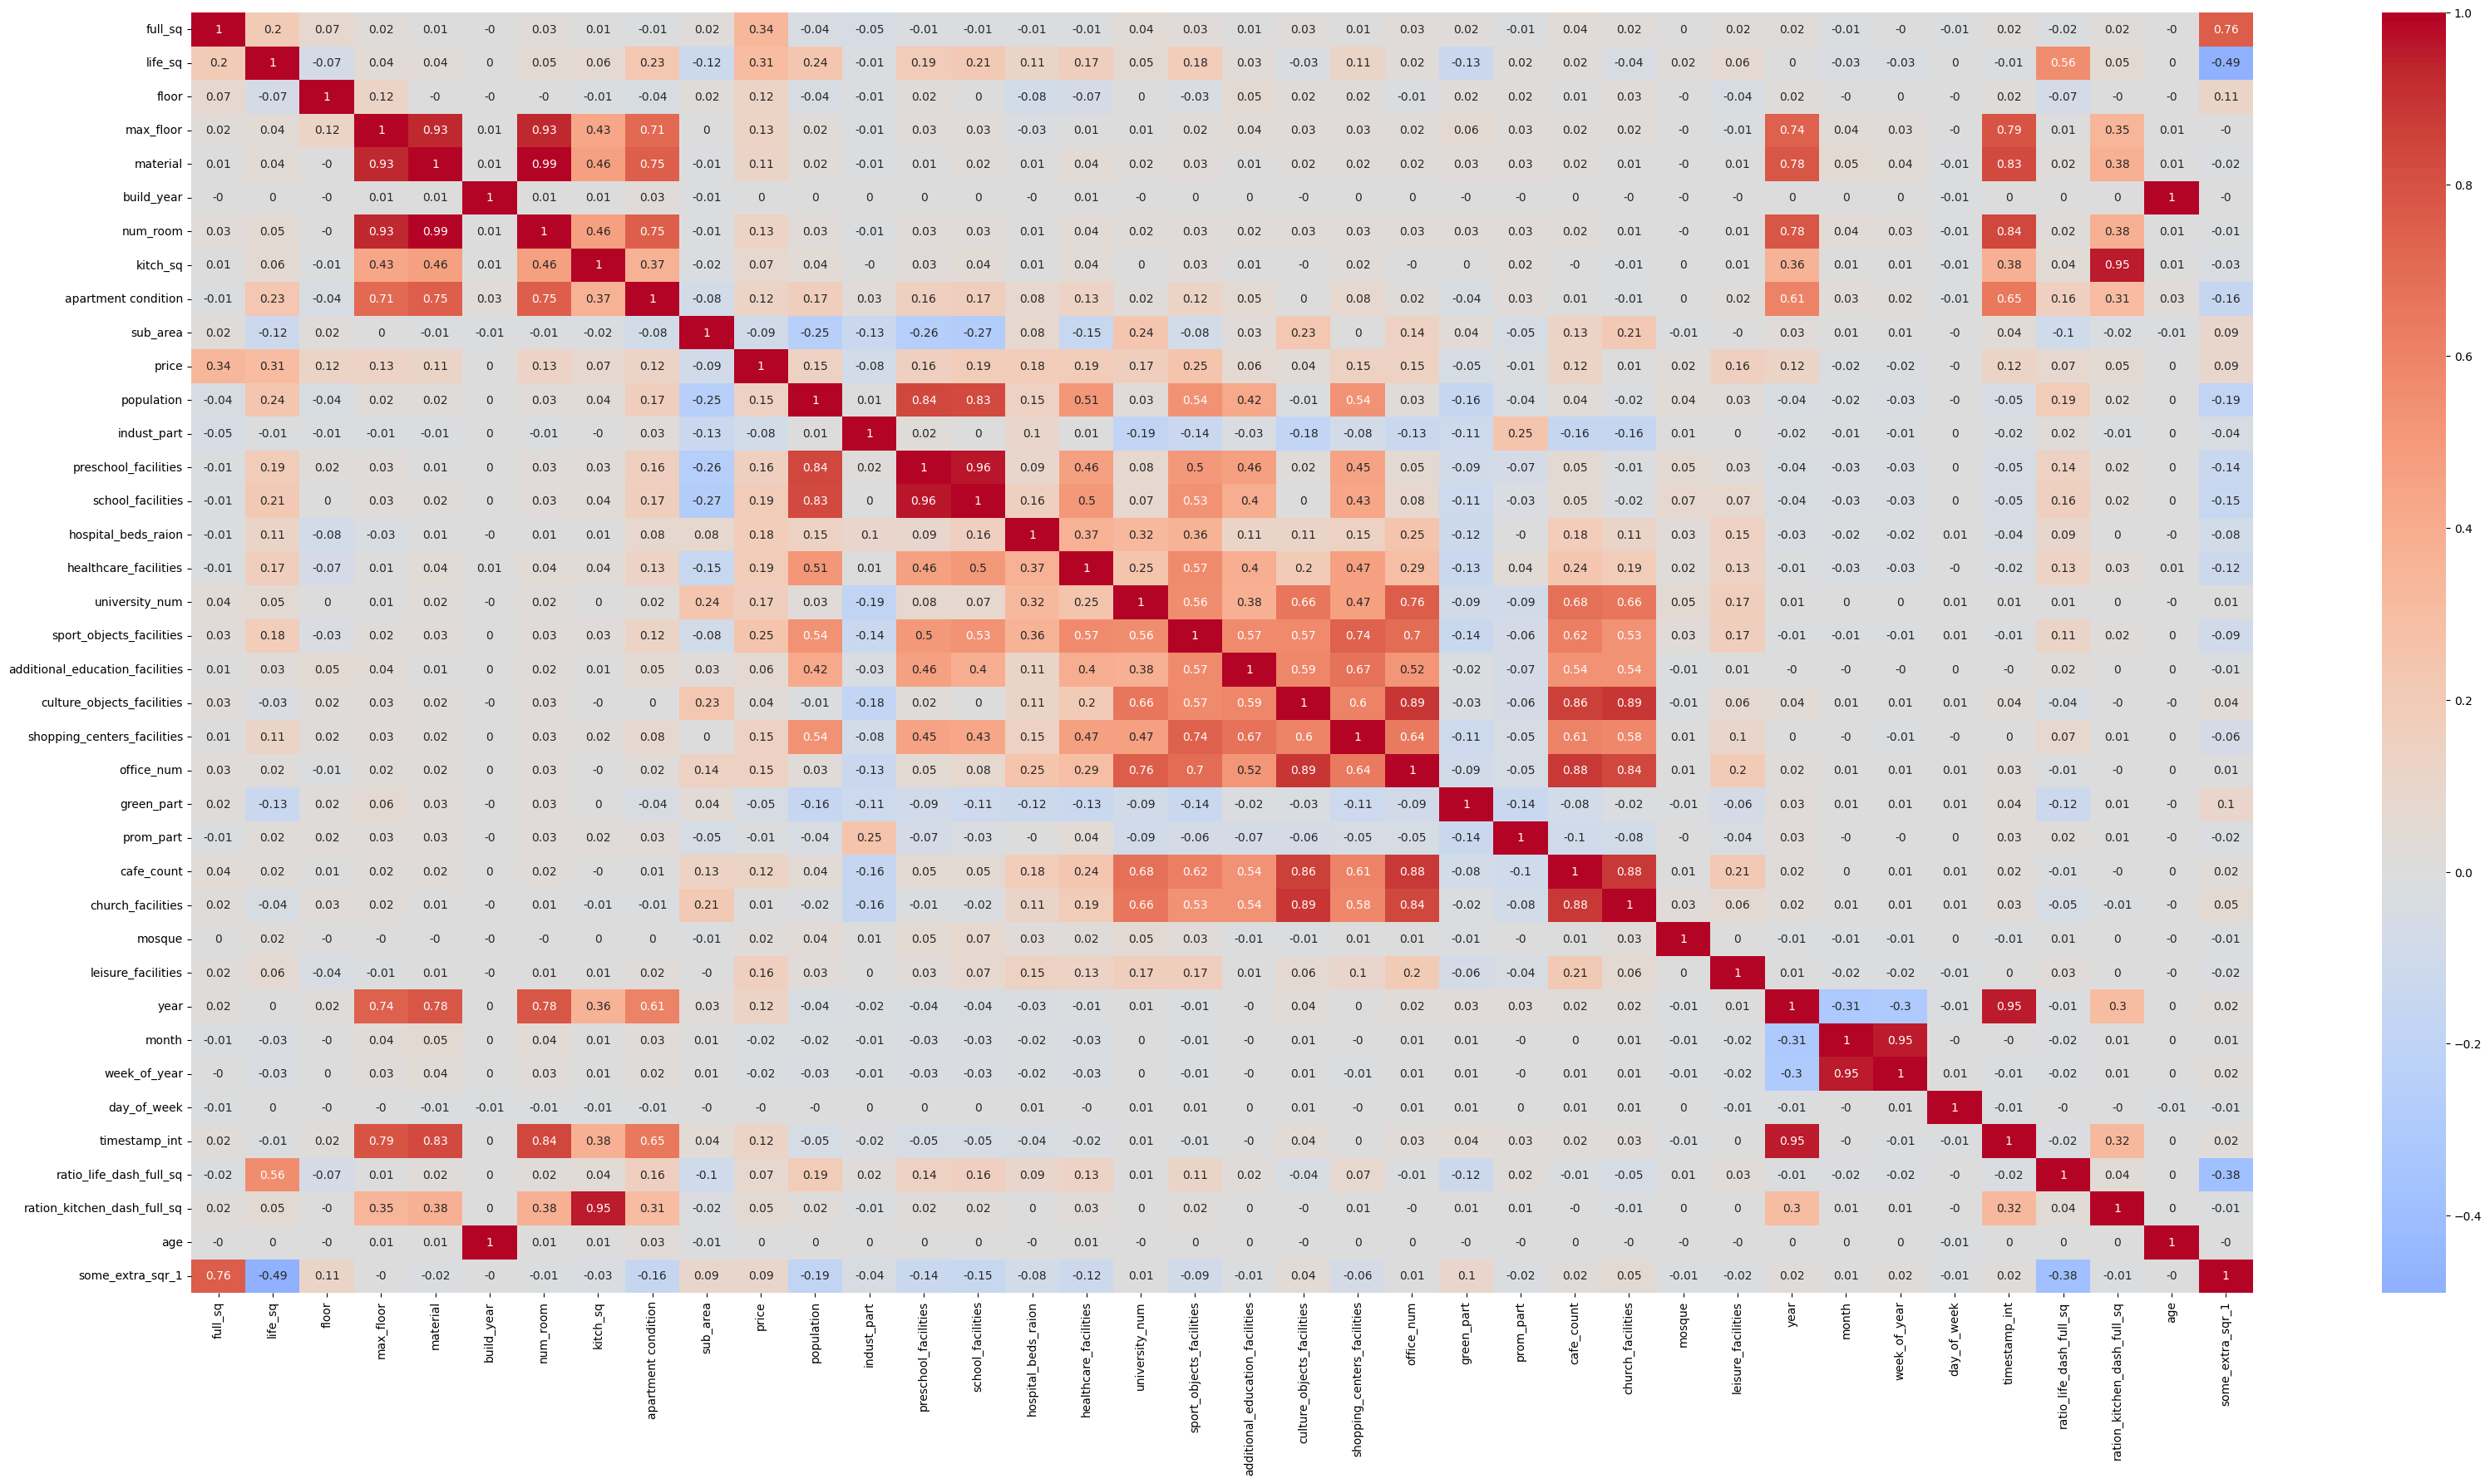

In [34]:
# Корреляционная матрица - некоторые признаки скоррелированы между собой

fig, ax = plt.subplots(figsize=(40, 20))

corr_mat = train_df.corr()
sns.heatmap(
    corr_mat.round(2),
    cmap='coolwarm',
    center=0,
    annot=True
)

fig.show();

In [48]:
feature_columns = [col for col in train_df.columns if col not in  ['price', 'timestamp']]
X = train_df[feature_columns].values

X_norm = (X - X.mean(axis=0)) / X.astype(np.float64).std(axis=0)
X_norm = X_norm.astype(float)

Z = np.cov(X_norm.T)

eig_vals, eig_vecs = eigen_qr(Z, 10**4)
eig_vals = eig_vals.diagonal()

In [45]:
# Отсортируем собственные значения по убыванию вместе с собственными векторами
eig_pairs = [
    (eig_val, eig_vec) for eig_val, eig_vec in zip(eig_vals, eig_vecs.T)
]

eig_pairs.sort(key=lambda x: x[0], reverse=True)

eig_vals = np.array([pair[0] for pair in eig_pairs])
eig_vecs = np.array([pair[1] for pair in eig_pairs])

In [50]:
target = train_df['price']

/var/folders/c_/t45fjn6j75357jk8wg1gpqsr0000gn/T/ipykernel_13519/297875559.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show();


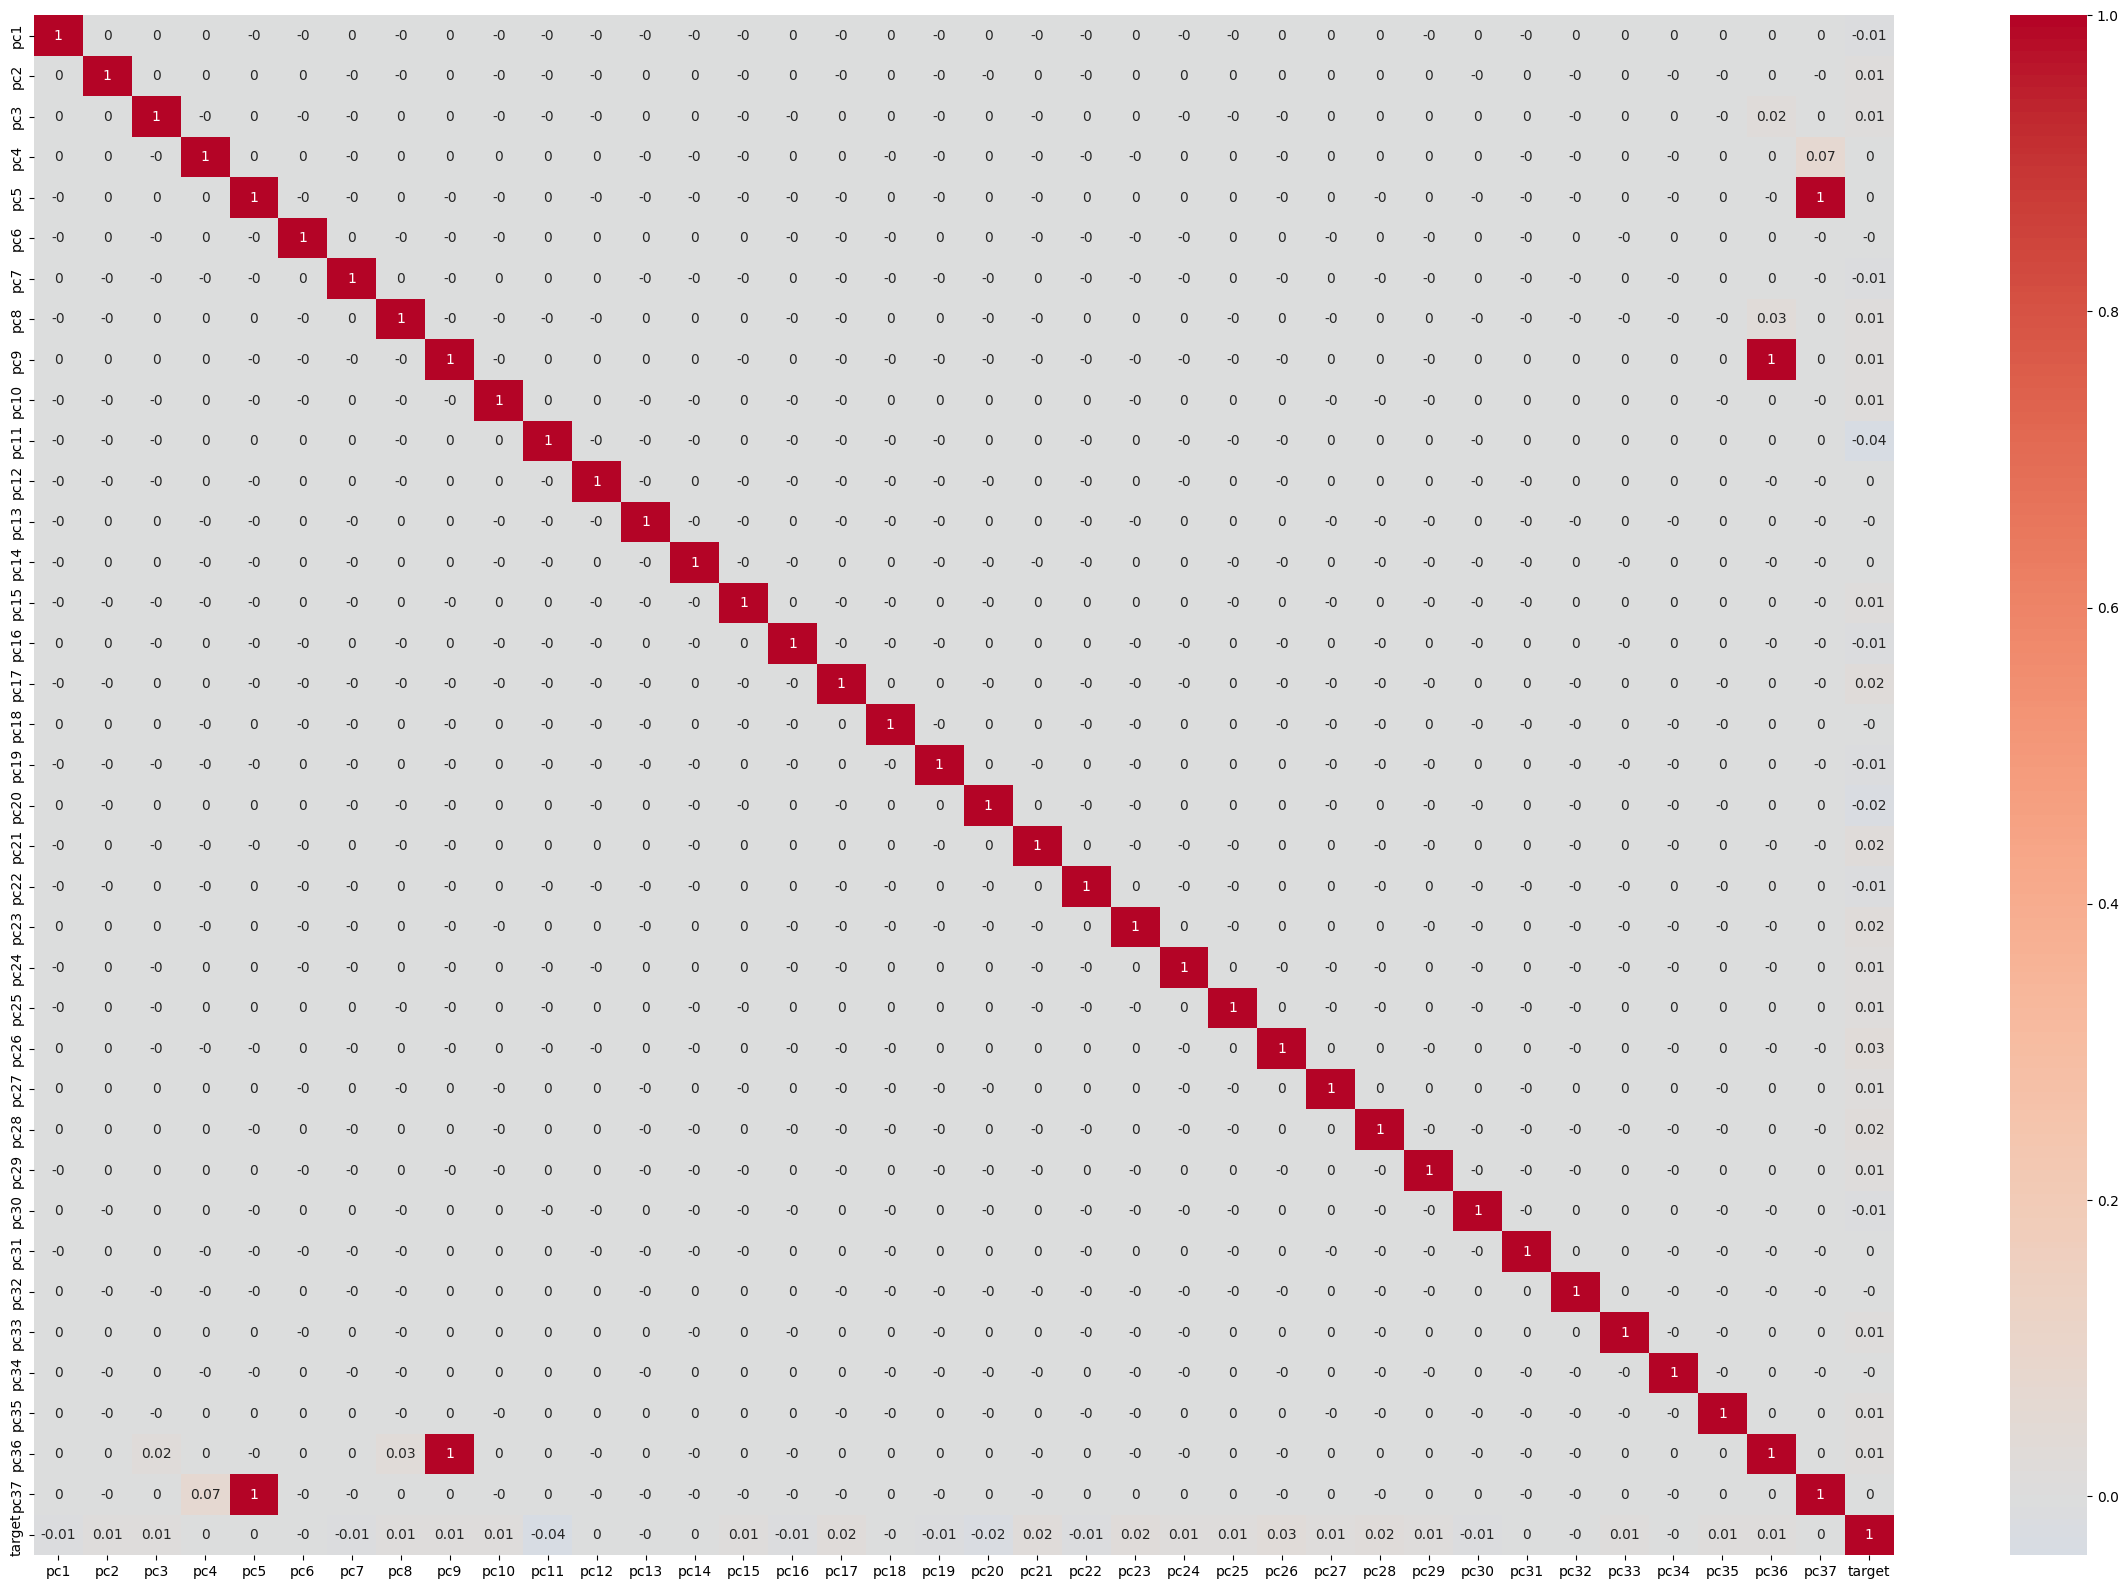

In [60]:
# Умножением нормированных данных и собственных векторов получим главные компоненты
# Главные компоненты мало коррелируют друг с другом, но коррелируют с таргетом
data_pca_full = X_norm@eig_vecs

df_pca_full = pd.DataFrame(data_pca_full, columns=['pc' + str(i) for i in range(1, X_norm.shape[1] + 1)])
df_pca_full['target'] = target

fig, ax = plt.subplots(figsize=(30, 20))

corr_pca = df_pca_full.corr()
sns.heatmap(
    corr_pca.round(2),
    cmap='coolwarm',
    center=0,
    annot=True
)

fig.show();

In [61]:
# посчитаем долю объясняемой компонентами дисперсии
explained_vars = [eig_val / eig_vals.sum() for eig_val in eig_vals]
explained_vars_cum = np.array(explained_vars).cumsum()
explained_vars_cum

array([0.17337274, 0.3216412 , 0.42145666, 0.47740277, 0.53141111,
       0.58445585, 0.62499267, 0.66398545, 0.70074557, 0.73278949,
       0.76014662, 0.78715355, 0.81307694, 0.83871   , 0.86233123,
       0.88326534, 0.90376818, 0.91805954, 0.93107995, 0.94165718,
       0.95200329, 0.961575  , 0.96989492, 0.97745201, 0.98303907,
       0.98706774, 0.99043238, 0.99297228, 0.99486371, 0.99634955,
       0.99767758, 0.99897406, 0.99974236, 0.99999178, 1.        ,
       1.        , 1.        ])

/var/folders/c_/t45fjn6j75357jk8wg1gpqsr0000gn/T/ipykernel_13519/2033845915.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


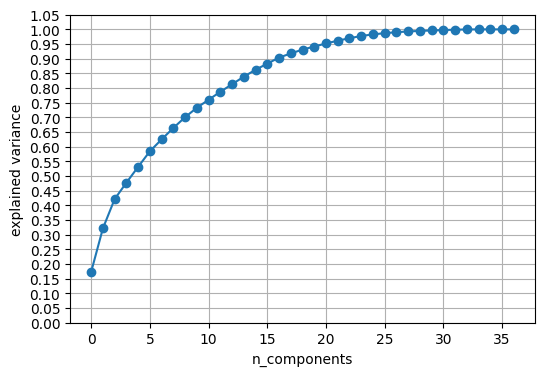

In [65]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(explained_vars_cum, marker='o')
ax.set_xlabel('n_components')
ax.set_ylabel('explained variance')
ax.set_yticks(np.arange(0, 1.1, 0.05)) 
ax.grid()
fig.show()


In [73]:
# Чтобы сохранить 95% дисперсии необходимо взять первые 9 компонент
# сверим результат с реализацией из sklearn'а
# т.к. знаки могут чередоваться по-разному (при этом дисперсия будет той же)
# сравниваем по модулю

pc9_vecs = eig_vecs[:, :21]
pc9_data = X_norm@pc9_vecs

pca_house = PCA(.95)
principalComponents_house = pca_house.fit_transform(X_norm)

assert np.allclose(pca_house.explained_variance_ratio_, explained_vars[:21])
assert np.allclose(np.abs(principalComponents_house), np.abs(pc9_data))

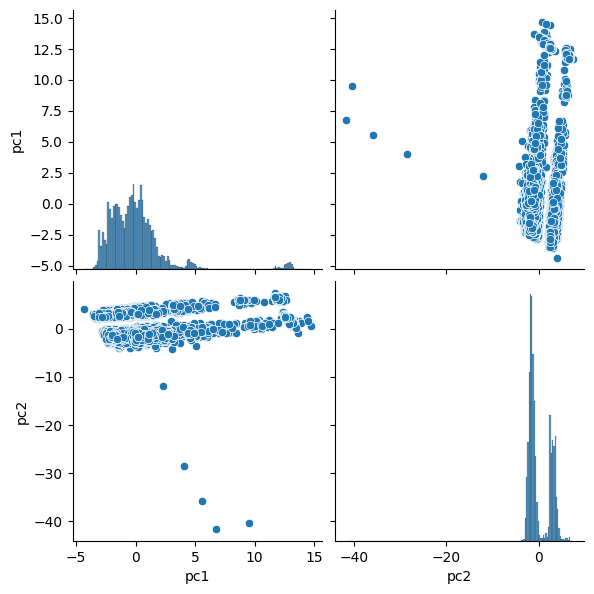

In [74]:
# Визуализируем первые две компоненты

pc2_vecs = eig_vecs[:, :2]
pc2_data = X_norm@pc2_vecs
df_pc2 = pd.DataFrame(pc2_data, columns=['pc1', 'pc2'])

sns.pairplot(df_pc2, height=3);

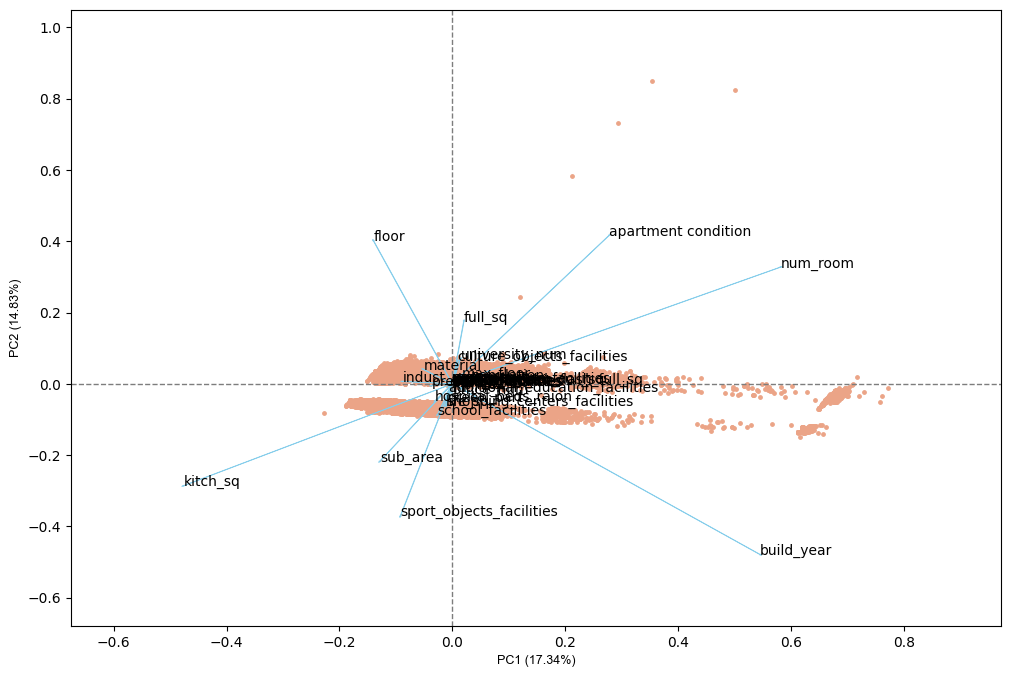

In [90]:
from bioinfokit.visuz import cluster

cluster.biplot(
    cscore=principalComponents_house,
    loadings=eig_vecs * np.sqrt(np.abs(eig_vals)),
    labels=train_df.columns,
    var1=round(explained_vars[0]*100, 2),
    var2=round(explained_vars[1]*100, 2),
    show=True,
    dim=(12, 8)
)

In [99]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

# X = train_df.drop(['price',	'timestamp'], axis=1)
# y = train_df['price']
# train_df.dropna(subset=['price'])
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=42)

catboost_model = CatBoostRegressor(iterations=557, depth=8, learning_rate=0.057610501661342545, 
                                   l2_leaf_reg= 0.023429475946447252, random_strength= 5.8897146499803865, 
                                   bagging_temperature= 0.7091341559901984, border_count= 205)

catboost_model.fit(X_train, y_train)



y_pred_val = catboost_model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred_val, squared=False)
rmse

0:	learn: 5075634.8099843	total: 3.67ms	remaining: 2.04s
1:	learn: 4942285.6910653	total: 6.59ms	remaining: 1.83s
2:	learn: 4823165.4092785	total: 9.98ms	remaining: 1.84s
3:	learn: 4713516.2917659	total: 13.2ms	remaining: 1.83s
4:	learn: 4593859.3686824	total: 16.3ms	remaining: 1.8s
5:	learn: 4497579.0322635	total: 19.5ms	remaining: 1.79s
6:	learn: 4411346.5999414	total: 22.5ms	remaining: 1.77s
7:	learn: 4336904.2819667	total: 25.5ms	remaining: 1.75s
8:	learn: 4262290.3194805	total: 28.8ms	remaining: 1.75s
9:	learn: 4187788.7661964	total: 32.3ms	remaining: 1.76s
10:	learn: 4106106.0164996	total: 35.9ms	remaining: 1.78s
11:	learn: 4049066.4320689	total: 39.1ms	remaining: 1.78s
12:	learn: 3983891.7648919	total: 42.4ms	remaining: 1.77s
13:	learn: 3925811.2730564	total: 45.6ms	remaining: 1.77s
14:	learn: 3875642.1017367	total: 49ms	remaining: 1.77s
15:	learn: 3810481.2882425	total: 52.5ms	remaining: 1.77s
16:	learn: 3761926.4630252	total: 56.4ms	remaining: 1.79s
17:	learn: 3713397.7185845	

2443255.457168639

In [ ]:
# Best parameters:  {'iterations': 557, 'depth': 8, 'learning_rate': 0.057610501661342545, 'l2_leaf_reg': 0.023429475946447252, 'random_strength': 5.8897146499803865, 'bagging_temperature': 0.7091341559901984, 'border_count': 205}
data_pca_full

In [96]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

# X = train_df.drop(['price',	'timestamp'], axis=1)
# y = train_df['price']
# train_df.dropna(subset=['price'])
X_train, X_test, y_train, y_test = train_test_split(pc9_data, target, test_size=0.2, random_state=42)

catboost_model = CatBoostRegressor(iterations=557, depth=8, learning_rate=0.057610501661342545, 
                                   l2_leaf_reg= 0.023429475946447252, random_strength= 5.8897146499803865, 
                                   bagging_temperature= 0.7091341559901984, border_count= 205)

catboost_model.fit(X_train, y_train)



y_pred_val = catboost_model.predict(X_test)

# y_pred_original = np.expm1(y_pred_val)
# y_pred_original = np.expm1(y_pred_val)

rmse = mean_squared_error(y_test, y_pred_val, squared=False)
rmse

0:	learn: 5117532.7274412	total: 5.35ms	remaining: 2.97s
1:	learn: 5038818.6255818	total: 9.27ms	remaining: 2.57s
2:	learn: 4940953.2708444	total: 13.4ms	remaining: 2.47s
3:	learn: 4853862.4224537	total: 17.6ms	remaining: 2.43s
4:	learn: 4749013.9815664	total: 21ms	remaining: 2.32s
5:	learn: 4663324.6767037	total: 24.5ms	remaining: 2.25s
6:	learn: 4577478.1367717	total: 27.8ms	remaining: 2.18s
7:	learn: 4507606.6377680	total: 31.1ms	remaining: 2.13s
8:	learn: 4433121.9095083	total: 34.4ms	remaining: 2.1s
9:	learn: 4363354.5104822	total: 37.8ms	remaining: 2.07s
10:	learn: 4311307.1202547	total: 41.1ms	remaining: 2.04s
11:	learn: 4244762.2447556	total: 44.3ms	remaining: 2.01s
12:	learn: 4187207.1041281	total: 48.9ms	remaining: 2.05s
13:	learn: 4136600.0532143	total: 54.1ms	remaining: 2.1s
14:	learn: 4082529.3827116	total: 58.5ms	remaining: 2.11s
15:	learn: 4034319.1967106	total: 61.9ms	remaining: 2.09s
16:	learn: 4000898.2930095	total: 65.4ms	remaining: 2.08s
17:	learn: 3965248.2574595	t

2695823.800194932